In [1]:
import numpy as np
import scipy as sc
import scipy.special as sp
import scipy.stats as ss
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import datetime
fontsize_axes = 18.0
fontsize_ticker = 16.0

# Profit and loss of blockchain miners

Let $\pi_{\text{BTC}}$ be the bitcoin price in USD and $\pi_{\text{BTC}}$ be the number of bitcoin as a bounty for finding a new block. The reward is worth

$$b = n_{\text{BTC}}\cdot\pi_{\text{BTC}}$$

In [2]:
r = requests.get('https://blockchain.info/ticker')
quote  = dict(r.json())
n_BTC, π_BTC = 6.25, quote["USD"]['last']
b = n_BTC * π_BTC
print('The BTC price is $' + str(π_BTC) )
print('The reward for finding a block amount to $' + str(b) )

The BTC price is $47883.82
The reward for finding a block amount to $299273.875


The electricity consumption estimated by the Cambridge Bitcoin Electricity Consumption Index [CBECI](https://cbeci.org/) in TWh per year is converted into kWh par hour and denoted by $W$.

In [3]:
tW_data = pd.read_csv("../Data/BTC_electricity_consumption.csv")
tW_data
tW_data['Date'] = pd.to_datetime(tW_data['Date and Time'])
tW_df = tW_data[['Date','GUESS']].rename(columns={"GUESS": "tW"})
# Operational cost of the network
W =  tW_df.tW.values[-1] * 10**9 / 365.25 / 24

print('On '+ str(tW_df.Date.values[-1]))
print('The network consumes ' + str(tW_df.tW.values[-1]) + ' tWh per year')  
print('The network consumes ' + str(W) + ' kWh per hour')  

On 2021-09-13T00:00:00.000000000
The network consumes 95.67642893329122 tWh per year
The network consumes 10914491.094374996 kWh per hour


The time unit is the hour, The network finds 6 new blocks eevry hour. The number of blocks up to time $t$ is a Poisson process $(N_t)_{t\geq0}$ of intensity $\lambda = 6$.

In [4]:
# Intensity of the Poisson process
λ = 6
print('The time unit is the hour, the Poisson process intensity is λ = ' + str(λ))

The time unit is the hour, the Poisson process intensity is λ = 6


The wealth of a miner is given by  

$$
R_t = u-c\cdot t+b\cdot \tilde{N}_t,
$$

where 

- $u$ is the initial reserves
- $c$ is the operational cost of mining
- $b$ the block finding reward
- $\tilde{N}_t$ is a Poisson process of intensity $p\lambda$ the number of blocks found by the considered miner until $t\geq0$

$p\in(0,1/2)$ corresponds to the share of the network hash power owned by the miner. The operational cost is given by

$$
c = p\cdot W\cdot \pi_{\text{W}}, 
$$

where $\pi_{W}$ is the prices ff one kWh of électricité. The net profit condition reads as 

$$
b\cdot\lambda -  W\cdot \pi_{\text{W}}>0
$$

and does not depend on $p$.

In [5]:
print('The net profit condition holds if the cost of electricity is lower than '
      + str(np.around(λ * b / W, decimals = 3))+
      ' when following the protocol')

The net profit condition holds if the cost of electricity is lower than 0.165 when following the protocol


The ruin time is defined by

$$
\tau_u = \inf\{t\geq0\text{ ; }R_t\leq0\}.
$$

The ruin probability up to time horizon $t\geq0$ is defined as 

$$
\psi(u,t) = \mathbb{P}(\tau_u \leq t).
$$

The ultimate ruin probability

$$
\psi(u) = \mathbb{P}(\tau_u < \infty)
$$

The miner surplus if ruin does not occur is given by
$$
V(u,t) = \mathbb{E}(R_t\mathbb{I}_{\tau_u>t}).
$$

The ruin probability and expected surplus up to an exponential time horizon $T\sim \text{Exp}(t)$ are denoted by

$$
\widehat{\psi}(u,t) = \mathbb{E}[\psi(u,T)],\text{ et } \widehat{V}(u,t) = \mathbb{E}[V(u,T)].
$$

Let us compare $\psi(u,t)$ and $\widehat{\psi}(u,t)$, and $V(u,t)$ et $\widehat{V}(u,t)$. The parameters are set as follows

$$
t = 6h,\pi_W = 0.06,\text{ and } p = 0.1.
$$

In [6]:
# Function to compute the ruin probability up to time t
def ψ_t(u, t, b, c, p, λ):
    n = ma.floor((c * t - u) / b)
    return(sum([u / (u + b * k) * ss.poisson.pmf(k, p * λ * (u + b * k) / c) for k in range(n+1)]))

# Function to compute the ultimate ruin probability
def ψ(u, b, c, p, λ):
    def f(x): 
        return(c * x + p * λ * (np.exp(-b*x) - 1))
    theta_star = sc.optimize.root_scalar(f, bracket=[np.log(p * b * λ / c) / b, 100],
                                            method='brentq').root
    return(np.exp(-theta_star * u))

# Function to compute the revenue function over a finite time horizon using Prop 1
def V_t(u, t, b, c, p, λ, K):
    # K is a truncation order for the infinite serie     
    U = [min(1, (u + b * k) / c / t) for k in range(K)]
    V = [max(0, u + k * b - c * t) * (-1) ** k * ss.poisson.pmf(k, p * λ * t) for k in range(K)]
    G_k = [1]
    for k in range(1,K,1):
        G_k.append(
            -sum([
                sp.binom(k,i) * U[i]**(k-i)*G_k[i] 
                for i in range(0,k,1)]))
    return(np.dot(V,G_k))

# Function to compute the value function over an exponential time horizon
def V_T(u, t, b, c, p, λ):
    γ = p * λ * b - c
    def f(x): 
            return(c * t * x + (1 + p * λ * t) - p *λ * t * np.exp(x * b) )
    rho_star = sc.optimize.root_scalar(f, bracket=[np.log(c / p * b * λ) / b-10, 
                                                      np.log(c / p / b / λ) / b],
                                          method='brentq').root
    return(γ * t + u - γ * t * np.exp(rho_star * u))

# Function to compute the ruin probability over an exponential time horizon via
def ψ_T(u, t, b, c, p, λ):
    
    def f(x): 
            return(c * t * x + (1 + p * λ * t) - p *λ * t * np.exp(x * b) )
    rho_star = sc.optimize.root_scalar(f, bracket=[np.log(c / p * b * λ) / b-10, 
                                                      np.log(c / p / b / λ) / b],
                                          method='brentq').root
    return(np.exp(rho_star * u))

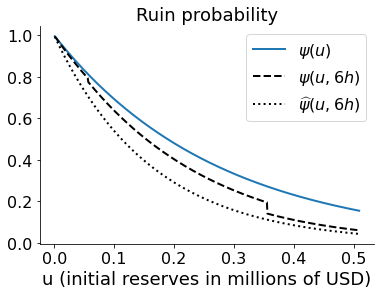

In [7]:
# Time horizon, price of the electricity and  hashpower
t, π_W, p = 6, 0.1, 0.1
# operational cost per hour
c = p * π_W * W
u_vec = np.arange(1000, 510000, 1000) # Sequence of initial reserves
ψ_u_t_vec = [ψ_t(u, t, b, c, p, λ) for u in u_vec]
ψ_u_t_vec
ψ_u_T_vec = [ψ_T(u, t, b, c, p, λ) for u in u_vec]
ψ_u_vec = [ψ(u, b, c, p, λ) for u in u_vec]
ψ_u_vec
plt.plot(u_vec *1e-6, ψ_u_vec, '-', label = '$\psi(u)$', linewidth=2)
plt.plot(u_vec *1e-6, ψ_u_t_vec, '--', label = '$\psi(u,6h)$', linewidth=2, color ='k')
plt.plot(u_vec*1e-6, ψ_u_T_vec, linestyle = 'dotted', label = '$\widehat{\psi}(u,6h)$', linewidth=2, color ='k')
plt.xlabel('u (initial reserves in millions of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize=fontsize_ticker)

sns.despine()

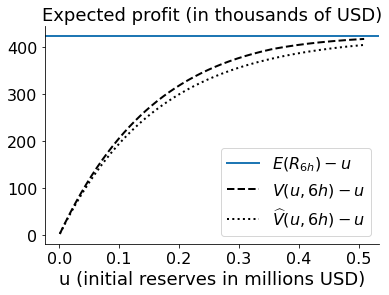

In [8]:
# Time horizon, price of the electricity and  hashpower
t, π_W, p = 6, 0.1, 0.1
c = p * π_W * W
u_vec = np.arange(1000, 510000, 1000) # Sequence of initial reserves
V_u_t_vec = np.array([V_t(u, t, b, c, p, λ, 40)-u for u in u_vec])/1000
V_u_T_vec = np.array([ V_T(u, t, b, c, p, λ)-u for u in u_vec])/1000
plt.axhline(y = (- c * t + p * λ * b * t)/1000, label = '$E(R_{6h})-u$', linewidth=2)
plt.plot(u_vec*1e-6, V_u_t_vec, '-', label = '$V(u,6h)-u$', linestyle = 'dashed', color = 'k', linewidth=2)
plt.plot(u_vec*1e-6, V_u_T_vec, linestyle = 'dotted', label = '$\widehat{V}(u,6h)-u$', color = 'k', linewidth=2)
plt.xlabel('u (initial reserves in millions USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in thousands of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize=fontsize_ticker)
sns.despine()

## Sensitivity analysis with respect to the model parameters

The ruin probability and expected profit are computed for various  $u,t,\pi_W$ et $p$. 

In [9]:
u_vec = np.arange(10000, 2050000, 50000)
t_vec = np.array([24, 7*24, 14*24])
π_W_vec = np.arange(0.05, 0.2, 0.01)
p_vec = np.arange(0.01, 0.21, 0.01)
ψ_V_df = pd.DataFrame({'u':[],'t':[],'π_W':[], 'p':[], 'ψ_u':[],'V_u_T':[], 'EG':[]})
for t in t_vec:
    for π_W in π_W_vec:
        for p in p_vec:
            c = p * π_W * W
            res = pd.DataFrame({'u':u_vec,
                        't':np.repeat(t, len(u_vec)), 
                        'π_W':np.repeat(π_W, len(u_vec)),
                        'p':np.repeat(p, len(u_vec)),
                        'ψ_u_T':[ψ_T(u, t, b, c, p, λ) for u in u_vec],
                        'ψ_u':[ψ(u, b, c, p, λ) for u in u_vec], 
                        'V_u_T':[ V_T(u, t, b, c, p, λ) for u in u_vec],
                       'EG': np.repeat(- c * t + p * λ * b * t, len(u_vec))})
            ψ_V_df = pd.concat([ψ_V_df, res])
# ψ_V_df

## Depending on $t$

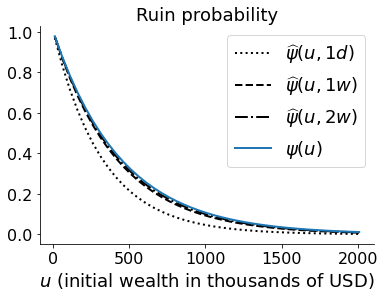

In [10]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
π_W = 0.12
p = 0.1
selector = (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
t_vec_ex = np.array([24, 24*7, 24*14]) 
time_horizon = np.array(['1d', '1w', '2w'])
for k in range(len(t_vec_ex)):
    c = p * π_W * W
#     plt.plot(u_vec, ψ_V_df.ψ_u[(selector) & (ψ_V_df.t == t_vec_ex[k])].values, color = 'k', alpha = 0.2)
    plt.plot(u_vec/1000, ψ_V_df.ψ_u_T[(selector) & (ψ_V_df.t == t_vec_ex[k])].values, color = 'k',
             linestyle = linestyles[k], label = '$\widehat{ψ}(u,'+time_horizon[k] +')$',linewidth = 2)
plt.plot(u_vec/1000, ψ_V_df.ψ_u[(selector) & (ψ_V_df.t == t_vec_ex[0])].values,
        linestyle = 'solid', label = '$\psi(u)$', linewidth = 2)
plt.xlabel('$u$ (initial wealth in thousands of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = fontsize_axes)

sns.despine()

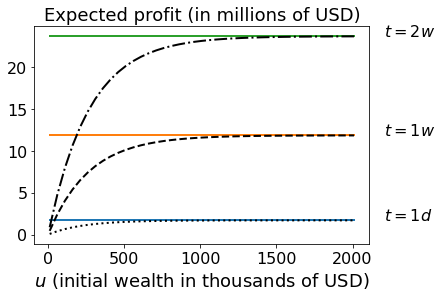

In [11]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
π_W = 0.1
p = 0.1
selector = (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
t_vec_ex = np.array([24, 24*7, 24*14]) 
time_horizon = np.array(['1d', '1w', '2w'])
for k in range(len(t_vec_ex)):
    c = p * π_W * W
    plt.plot(u_vec/1000, (ψ_V_df.EG[(selector) & (ψ_V_df.t == t_vec_ex[k])].values)/1000000, linewidth = 2)
    plt.plot(u_vec/1000, (ψ_V_df.V_u_T[(selector) & (ψ_V_df.t == t_vec_ex[k])].values -u_vec)/1000000, color = 'k',linewidth = 2, 
             linestyle = linestyles[k])
    plt.text(u_vec[-1]/1000 + 200, (- c * t_vec_ex[k] + p * λ * b * t_vec_ex[k]+50000)/1000000, '$t = '+time_horizon[k]+'$', fontsize = fontsize_ticker)
plt.xlabel('$u$ (initial wealth in thousands of USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)



### Depending on $\pi_W$

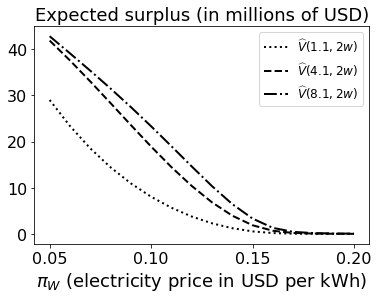

In [12]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
t = 24*14
p = 0.1
selector = (np.around(ψ_V_df.t.values, decimals = 0) == t) & (np.around(ψ_V_df.p.values, decimals = 2) == p)
u_vec_ex = np.array([110000, 410000, 810000]) 
u_vec_names = np.array(['1.1', '4.1', '8.1'])

for k in range(len(u_vec_ex)):
    plt.plot(π_W_vec, ψ_V_df.V_u_T[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values/1000000,
             color = 'k', linestyle = linestyles[k], label = '$\widehat{V}('+u_vec_names[k]+', 2w)$', linewidth = 2)
plt.xlabel('$\pi_W$ (electricity price in USD per kWh)', fontsize = fontsize_axes)
plt.title('Expected surplus (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)

### Depending on $p$

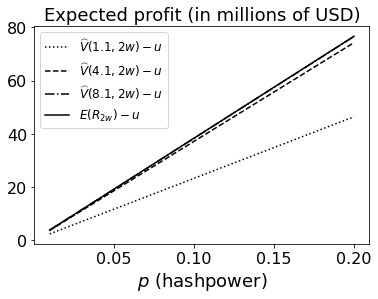

In [13]:
linestyles = ['dotted', 'dashed', 'dashdot']
#Selection of the data
t = 24*14
π_W = 0.06
selector = (np.around(ψ_V_df.t.values, decimals = 0) == t) & (np.around(ψ_V_df.π_W.values, decimals = 3) == π_W)
u_vec_ex = np.array([110000, 410000, 810000]) 
u_vec_names = np.array(['1.1', '4.1', '8.1'])

for k in range(len(u_vec_ex)):
    plt.plot(p_vec, (ψ_V_df.V_u_T[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values - u_vec_ex[k])/1000000,
             color = 'k', alpha = 1,linestyle = linestyles[k], label = '$\widehat{V}('+u_vec_names[k]+',2w)-u$')

plt.plot(p_vec, (ψ_V_df.EG[(selector) & (np.around(ψ_V_df.u.values, decimals = 0) == u_vec_ex[k])].values)/1000000,
             color = 'k', alpha = 1,linestyle = 'solid', label = '$E(R_{2w})-u$')
plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)

## When joining a mining pool

### The miner's side

Denote by $(M_t)_{t\geq0}$ the number of *shares* found by the network, it a Poisson process of intensityt $\mu = \lambda / q$, where $q$ denotes the relative difficulty of finding a share compared to finding a block. 

The miner that joins a PPS pool wealth is given by 

$$
R_t = u-c\cdot t+(1-f)\cdot q\cdot b\cdot \tilde{M}_t,
$$

where 

- $\tilde{M}_t$ is a Poisson process of intensity $p\mu$
- $f\in(0,1)$ is the pool fee

The net pofit condition now depends on the pool management fee $f$ as 


$$
b\cdot\mu\cdot (1-f)\cdot q -  W\cdot \pi_{\text{W}}>0
$$

The fees of the major mining pool amounts to $2\%\sim 2.5\%$

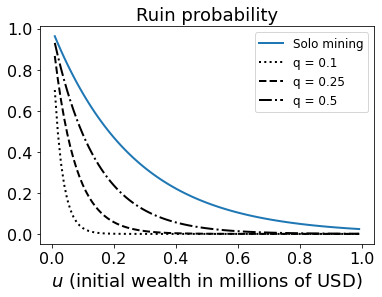

In [14]:
u, t, q, f  = 1000000, 24*7, 0.05, 0.025
π_W = 0.1
c = p * π_W * W
q_vec = [0.1, 0.25, 0.5]
u_vec = np.arange(10000, 1000000, 10000)
linestyles = ['dotted', 'dashed', 'dashdot']
ψ_solo = [ψ_T(u, t, b, c, p, λ) for u in u_vec]
plt.plot(u_vec *1e-6, ψ_solo,linewidth =2, label = "Solo mining")
for k,q in enumerate(q_vec):
    ψ_pool = [ψ_T(u, t, b * q * (1 - f), c, p, λ / q) for u in u_vec]
    plt.plot(u_vec *1e-6, ψ_pool,linewidth =2, linestyle = linestyles[k], color = "k", label = "q = "+str(q))
plt.xlabel('$u$ (initial wealth in millions of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)
# ψ_pool
# print(V_T(u, t, b * q * (1 - f), c, p, λ / q), V_T(u, t, b, c, p, λ))
# ψ_T(u, t, b * q * (1 - f), c, p, λ / q), ψ_T(u, t, b, c, p, λ)

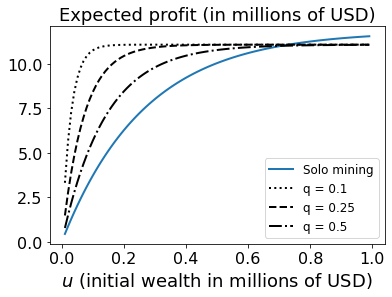

In [15]:
u, t, q, f  = 1000000, 24*7, 0.05, 0.025
π_W = 0.1
c = p * π_W * W
q_vec = [0.1, 0.25, 0.5]
u_vec = np.arange(10000, 1000000, 10000)
linestyles = ['dotted', 'dashed', 'dashdot']
V_solo = [V_T(u, t, b, c, p, λ) for u in u_vec]
plt.plot(u_vec *1e-6, (V_solo-u_vec)*1e-6,linewidth =2, label = "Solo mining")
for k,q in enumerate(q_vec):
    V_pool = [V_T(u, t, b * q * (1 - f), c, p, λ / q) for u in u_vec]
    plt.plot(u_vec *1e-6, (V_pool - u_vec)*1e-6,linewidth =2, linestyle = linestyles[k], color = "k", label = "q = "+str(q))
plt.xlabel('$u$ (initial wealth in millions of USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)

A miner will always choose a low $q$ for given level of pool fee.

### The pool manager side

The wealth of the pool manager is given 
$$
R_t= u - \sum_{i=1}^{M_t} W_i +\sum_{j=1}^{N_t} B_j,\text{ }t\geq0.
$$
where 
- $(M_t)_{t\geq0}$ and $(N_t)_{t\geq0}$ are Poisson processes with intensity $\mu^\ast=\mu- \lambda$ and $\lambda$
- $(W_i)_{i\geq0}$ and $(B_j)_{j\geq0}$ are two independent sequence of \iid exponentially distributed random variables with mean $w$ and $b^\ast = b-w$


In [321]:
# u, t, q, f, λ  = 100000, 24*7, 0.5, 0.025, 0.1 * 6

# μ = λ / q
# μstar = μ - λ 
# w = b * q * (1 - f)
# bstar = b - w
# print(λ * b - μstar * w)
# α, β,γ = (bstar * w * (1 + (λ + μstar) * t)) / t, (-b*λ*t + μstar * t * w - b + w)/t, -1/t
  
# Δ = β**2 - 4 * α * γ
# Rstar = (-β + np.sqrt(Δ))/ 2/α
# print(Δ, Rstar)
# print(ψ_pool_T(u, t, b, λ, q, f), V_pool_T(u, t, b, λ, q, f))

def V_pool_T(u, t, b, λ, q, f):
    μ = λ / q
    μstar = μ - λ
    w = b * q * (1 - f)
    bstar = b - w
    g = 1/t + μstar + λ
    α, β,γ = g*bstar * w, μstar * bstar - λ * w - g*(bstar - w) , -1/t
    Δ = β**2 - 4 * α * γ
    Rstar = (-β + np.sqrt(Δ))/ 2/α
#     print(Rstar)
    return((1-Rstar * w) * (w - t*(λ * bstar - μstar * w)) * np.exp(-Rstar*u)  + u + t*(λ * bstar - μstar*w))
def Exp_pool_T(u, t, b, λ, q, f):
    μ = λ / q
    μstar = μ - λ
    w = b * q * (1 - f)
    bstar = b - w

    return( u + t*(λ * bstar - μstar*w))

def ψ_pool_T(u, t, b, λ, q, f):
    μ = λ / q
    μstar = μ - λ
    w = b * q * (1 - f)
    bstar = b - w
    g = 1/t + μstar + λ
    α, β,γ = g*bstar * w, μstar * bstar - λ * w - g*(bstar - w) , -1/t
    Δ = β**2 - 4 * α * γ
    Rstar = (-β + np.sqrt(Δ))/ 2/α
    return((1-Rstar * w) *np.exp(-Rstar*u))


83228.97992402459

### Ruin and expected profit of the pool manager in terms of risk transfer

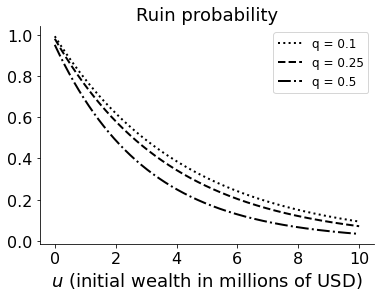

In [262]:
u, t, q, f, p, λ  = 1000000, 24*7, 0.05, 0.025, 0.4, 6
q_vec = [0.1, 0.25, 0.5]
u_vec = np.arange(0, 10000000, 1000)
linestyles = ['dotted', 'dashed', 'dashdot']
# V_manager = [V_pool_T(u, t, b, λ, q, f) for u in u_vec]
# V_manager
# plt.plot(u_vec *1e-6, (V_solo-u_vec)*1e-6,linewidth =2, label = "Solo mining")
for k,q in enumerate(q_vec):
    ψ_manager = [ψ_pool_T(u, t, b, λ * p, q, f) for u in u_vec]
    plt.plot(u_vec*1e-6, ψ_manager,linewidth =2, linestyle = linestyles[k], color = "k", label = "q = "+str(q))
plt.xlabel('$u$ (initial wealth in millions of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)
sns.despine()

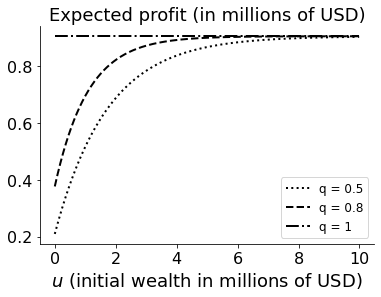

In [332]:
u, t, q, f, p, λ  = 1000000, 24*7, 1 ,0.03, 0.1, 6
q_vec = [ 0.5, 0.8,1]
u_vec = np.arange(0, 10000000, 10000)
linestyles = ['dotted', 'dashed', 'dashdot']
# V_manager = [V_pool_T(u, t, b, λ, q, f) for u in u_vec]
# V_manager

# plt.plot(u_vec *1e-6, (V_solo-u_vec)*1e-6,linewidth =2, label = "Solo mining")
for k,q in enumerate(q_vec):
    V_manager = [V_pool_T(u, t, b, λ*p, q, f) for u in u_vec]
    plt.plot(u_vec*1e-6, (V_manager - u_vec)*1e-6,linewidth =2, linestyle = linestyles[k], color = "k", label = "q = "+str(q))
plt.xlabel('$u$ (initial wealth in millions of USD)', fontsize = fontsize_axes)
plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)
sns.despine()

### Risk on centralization

First, we study the expected profit as a function of the pool management fee $f$ and the pool total haspower $p$

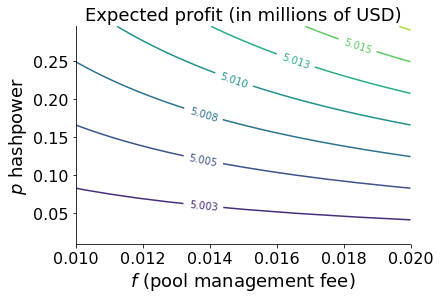

In [280]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

u, t, q, f, p, λ  = 5000000, 24*7, 0.25, 0.025, 0.1, 6*0.01
f = np.arange(0.01, 0.025, 0.005)
p = np.arange(0.01, 0.3, 0.005)
F, P = np.meshgrid(f, p)
V = V_pool_T(u, t, b, λ * P, q, F) *1e-6
fig, ax = plt.subplots()
CS = ax.contour(F, P, V)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
# plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
ax.tick_params(labelsize=fontsize_ticker)
ax.set_xlabel('$f$ (pool management fee)', fontsize = fontsize_axes)
ax.set_ylabel('$p$ hashpower', fontsize = fontsize_axes)
sns.despine()

A larger pool can maintain a given level of profit while providing a smaller fee and therefore attract more miners and grows even more. 

To defend itself against this situation a smaller pool may act on the magnitude of the risk transfer. Let us have a look at the expected profit as a function of $f$ and $q$ for 
- miner 1 with hashpower $p_1=0.05$
- miner 2 with haspower $p_2 = 0.2$

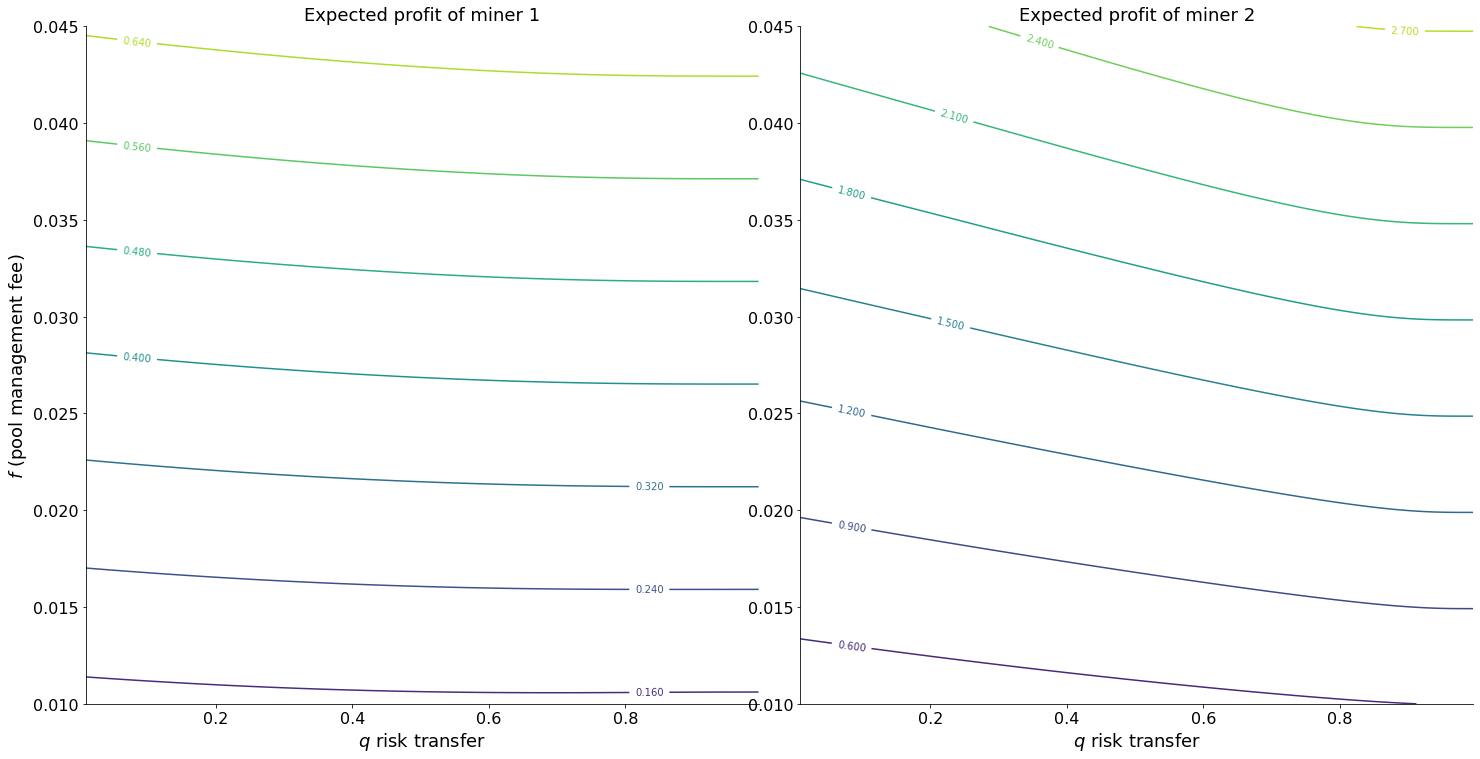

In [355]:
u, t, q, f, λ  = 5000000, 24*7, 0.1, 0.025, 6
p1, p2 = 0.05, 0.2 
f = np.arange(0.01, 0.05, 0.005)
q = np.arange(0.01, 1, 0.005)
Q , F = np.meshgrid(q, f)
V = [V_pool_T(u, t, b, λ * p1, Q, F)  - u, V_pool_T(u, t, b, λ * p2, Q, F)  - u]
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.tight_layout()

for k in range(2): 
    CS = ax[k].contour(Q, F, V[k]*1e-6)
    ax[k].clabel(CS, inline=True, fontsize=10)
    ax[k].set_title('Expected profit of miner '+str(k+1), fontsize = fontsize_axes)
    ax[k].tick_params(labelsize=fontsize_ticker)
    ax[0].set_ylabel('$f$ (pool management fee)', fontsize = fontsize_axes)
    ax[k].set_xlabel('$q$ risk transfer', fontsize = fontsize_axes)
sns.despine()

- The expected profit under ruin of a smaller mining pool is less sensitive to a smaller value of $q$ where a bigger mining pool might have to increase the fee to decrease $q$ while maintaining the same expected profit. 

The fact that miner are heterogeneous in terms of risk aversion and that mining pool will offer various risk coverage (by tuning the value of $q$) depending on their hashpower could make decentralization prevail. The strategic behaviors of the different player require a game theoretic approach. 

# When doing selfish mining

Selfish mining entails a waste of resources for the attacker and require a lower cost of electricity to be profitable. Selfish mining is equivalent to following the protocol only if the connectivity is $1$.

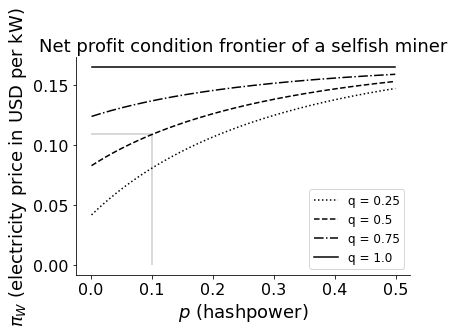

In [360]:
λ, p =6, 0.1
def f_πW(p,q): return((1/ p / W) * b * λ * (q * p * (1-p)**2 + 4 * p**2 - 2 * p**3)/(1 + 2 * p - p**2))

linestyles = ['dotted', 'dashed', 'dashdot', 'solid']
q_vec_ex = np.array([0.25, 0.5, 0.75, 1])

for k in range(len(q_vec_ex)) :  
    plt.plot(np.arange(0.001, 0.5 ,0.001), np.array([f_πW(p,q_vec_ex[k]) for p in np.arange(0.001,0.5,0.001)]),
             color = 'k', alpha = 1, linestyle =linestyles[k], label = 'q = '+str(q_vec_ex[k]))
    
plt.vlines(x=0.1, ymin=0, ymax=f_πW(0.1,0.5), color = 'k', linestyle = '-',alpha = 0.2)
plt.hlines(y=f_πW(0.1,0.5), xmin=0, xmax=0.1, color = 'k', linestyle = '-', alpha = 0.2)
plt.tick_params(labelsize=fontsize_ticker)
# plt.axvline(0, color = 'k', alpha = 0.5)
# plt.axhline(0, color = 'k', alpha =0.5)
plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.ylabel('$π_W$ (electricity price in USD per kW)', fontsize = fontsize_axes)
plt.title('Net profit condition frontier of a selfish miner', fontsize = fontsize_axes)

plt.legend(fontsize = 12)
sns.despine()
# plt.savefig("../Figures/nbc_selfish_q.pdf", bbox_inches='tight')

Selfish mining is strategic if we take a time horizon long enough to include a difficulty adjustments. Let us take $t = 4w$ to have two segment (with a difficulty adjustment right in the middle) and compare the expected profit of miner following the protocol during both segment and a selfish miner that does selfish mining over the first segment and resume to following the protocol over the second segment. 



In [384]:
# Hashrate of the network
H = tW_df.tW.values[-1] * 10**18 * 600
# Estimated target on the first segment. 
L = 2**256 / H
print("The current target is "+str(L)+" compared to " + str(L * H))

The current target is 2.017077952711674e+54 compared to 1.157920892373162e+77


In [385]:
# Time horizon, price of the electricity and  hashpower
u_vec = np.arange(5000, 1105000, 5000)
t_vec = np.array([28*24])
π_W_vec = np.arange(0.1, 0.18, 0.01)
p_vec = np.arange(0.15, 0.21, 0.05)
V_protocol_df = pd.DataFrame({'u':[],'t':[],'π_W':[], 'p':[],'u_2':[], 'EG':[], 'psi_S1':[]})
for t in t_vec:
    for π_W in π_W_vec:
        for p in p_vec:
            c = p * π_W * W
            res = pd.DataFrame({'u':u_vec,
                        't':np.repeat(t, len(u_vec)), 
                        'π_W':np.repeat(π_W, len(u_vec)),
                        'p':np.repeat(p, len(u_vec)),
                        'V_T':[ V_T(u, t, b, c, p, λ) for u in u_vec],
                        'psi_T':[ψ_T(u, t, b, c, p, λ) for u in u_vec],
                       'EG': [p*λ*b - c for u in u_vec] 
                               })
            V_protocol_df = pd.concat([V_protocol_df, res])


In [386]:
q = 0.75
# Arrival rate in the blockchain when a miner with hashpower p is mining selfishly
λ_1_vec = [λ * (1 - p * (1 - p) / (1 + 2 * p - p**2)) for p in p_vec]
# Duration of the first segement when a miner with hashpower p is mining selfishly
t_1_vec = [ 2016 / λ / (1 - p * (1 - p) / (1 + 2 * p - p**2)) for p in p_vec]
# The revenue over the first segement is evaluated through maple and reported as the variable u_2
V_self1_df = pd.read_csv("../maple/V_seg1_data.csv", header = 0).rename(columns = {'&lambda;_1':'λ_1', 'V_T':'u_2','pkW':'π_W'}).drop('Unnamed: 0', axis = 1)

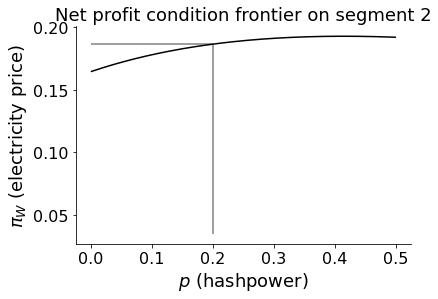

In [387]:
# Target resulting from selfish mining
L_2 = L * V_self1_df['t_1'].values / 336
# Number of hashes
λ_2 = 1 / ( 2**256 / L_2 / H / 6)

# #net benefit condition
def π_W(p): return(2016 / 336 * b * 6 / λ / (1 - p * (1 - p) / (1 + 2 * p - p**2)) / W )

plt.plot(np.arange(0.001,0.5,0.001), np.array([π_W(p) for p in np.arange(0.001,0.5,0.001)]),
         color = 'k', alpha = 1, linestyle ='solid')

plt.xlabel('$p$ (hashpower)', fontsize = fontsize_axes)
plt.ylabel('$π_W$ (electricity price)', fontsize = fontsize_axes)
plt.title('Net profit condition frontier on segment 2', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.vlines(x=0.2, ymin=0.035, ymax=π_W(0.2), color = 'k', linestyle = '-', alpha =0.5)
plt.hlines(y=π_W(0.2), xmin=0, xmax=0.2, color = 'k', linestyle = '-', alpha =0.5)

sns.despine()

In [388]:
def V_T_bis(u, t, b, p, λ, pkW, W):
    c = p * pkW * W
    γ = p * λ * b - c
    def f(x): 
            return(c * t * x + (1 + p * λ * t) - p *λ * t * np.exp(x * b) )
    rho_star = sc.optimize.root_scalar(f, bracket=[np.log(c / p * b * λ) / b-10, 
                                                      np.log(c / p / b / λ) / b],
                                          method='brentq').root
    return(γ * t + u - γ * t * np.exp(rho_star * u))
# Function to compute the average profit when mining selfishly 
def η(p, q, b, λ, π_W, W): 
    # pkW price per kW
    # Electricity consumption of the network per year     
    c = p * π_W * W
    denom = 1+2*p-p**2
    p_U = [(1+p*(1-p)+p*(1-p)**2*(1-q))/denom, (p*q*(1-p)**2)/denom, (p**2+p**2*(1-p))/denom]
    return b*λ*(p_U[1]+2*p_U[2]) - c

#Computation of the arrival rates of block for the second segment
V_self1_df['λ_2'] = 1/( 2**256 / L_2 / H / 6)
V_self1_df['t_2'] = 2016 / V_self1_df['λ_2']
V_self1_df['V_T'] = [V_T_bis(V_self1_df.u_2[k], V_self1_df.t_2[k], b, V_self1_df.p[k], V_self1_df.λ_2[k], V_self1_df.π_W[k],
                             W) for k in range(len(V_self1_df['λ_2']))]

#Selection of the data
π_W = 0.15
p = 0.2

# operational cost per hour
c = p * π_W * W
select_self = (np.around(V_self1_df.π_W.values, decimals = 3) == π_W) & (np.around(V_self1_df.p.values, decimals = 2) == p)
select_pro = (np.around(V_protocol_df.π_W.values, decimals = 3) == π_W) & (np.around(V_protocol_df.p.values, decimals = 2) == p)

print("The  average gain per time unit amounts to $" + str((p*λ*b - c)) + " when following the protocol")
print("The expected gain amounts to $" + str((p*λ*b - c)*28*24) + " when following the protocol")
print("The average gain per time unit amounts to $" + str(η(p, q, b, λ, π_W, W)) + " when mining selfishly on first segment")
print("The average gain per time unit amounts to  $" + 
      str((p* V_self1_df.λ_2[(select_self)].values[0] * b - c)) + 
      "  when resuming to protocol on second segment")
print("The expected gain amounts to $" + 
      str((p* V_self1_df.λ_2[(select_self)].values[0] * b - c)*V_self1_df.t_2[(select_self)].values[0]) + 
      " when resuming to protocol on second segment")

The  average gain per time unit amounts to $31693.917168750195 when following the protocol
The expected gain amounts to $21298312.33740013 when following the protocol
The average gain per time unit amounts to $-10556.512243014527 when mining selfishly on first segment
The average gain per time unit amounts to  $79577.73716875014  when resuming to protocol on second segment
The expected gain amounts to $23592458.548852988 when resuming to protocol on second segment


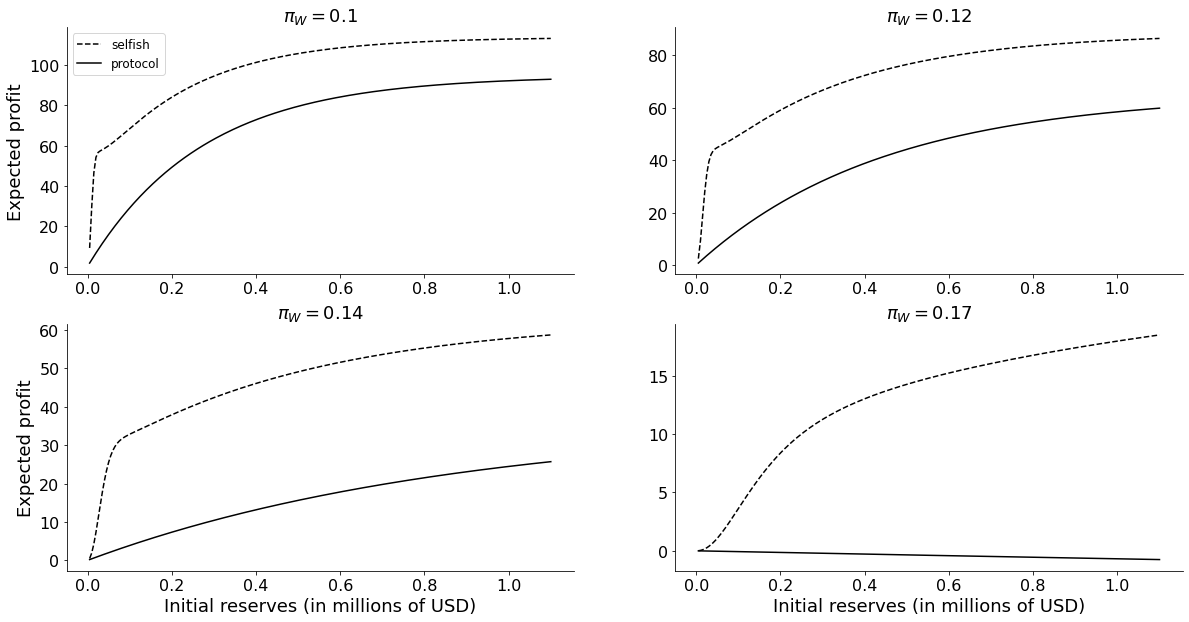

In [399]:
π_W_vec_ex = np.array([[ 0.1,0.12]
                       , [0.14, 0.17]])
p = 0.2

fig, axs = plt.subplots(len(π_W_vec_ex[: ,0]),len(π_W_vec_ex[0 ,:]), figsize=(20,10))
# fig.tight_layout()
for k in range(len(π_W_vec_ex[: ,0])):
    for l in range(len(π_W_vec_ex[0 ,:])):
        select_self = (np.around(V_self1_df.π_W.values, decimals = 3) == π_W_vec_ex[k,l])\
        & (np.around(V_self1_df.p.values, decimals = 2) == p)
        select_pro = (np.around(V_protocol_df.π_W.values, decimals = 3) == π_W_vec_ex[k,l])\
        & (np.around(V_protocol_df.p.values, decimals = 2) == p)

        axs[k,l].plot(u_vec/1000000, (V_self1_df.V_T[(select_self)] -u_vec)/1000000,
                 color = 'k', alpha = 1, linestyle ='dashed',label = 'selfish' )

        axs[k,l].plot(u_vec/1000000, (V_protocol_df.V_T[(select_pro)].values -u_vec )/1000000,
                 color = 'k', alpha = 1, linestyle ='solid', label = 'protocol' )
        axs[k,l].set_title('$\pi_W = $' + str(π_W_vec_ex[k,l]), fontsize = fontsize_axes)
        axs[k,l].tick_params(labelsize=fontsize_ticker)
        axs[k,0].set_ylabel('Expected profit', fontsize = fontsize_axes)
        axs[1,l].set_xlabel('Initial reserves (in millions of USD)', fontsize = fontsize_axes)
    axs[0,0].legend(fontsize = 12)
    sns.despine()
